# Flight Delay Status Classification

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
import pyspark.ml.feature as ftr
import pyspark.ml as ml
 
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml import PipelineModel
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA
 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline

### Data Loading and Initial Exploration

In [2]:
spark = SparkSession.builder.appName("FlightDelayPrediction").getOrCreate()

In [3]:
flight_path = 'gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Combined_Flights_2018-2022.parquet'
airport_path = 'gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Airports'

flight = spark.read.parquet(flight_path)
airport = spark.read.parquet(airport_path)

In [4]:
flight.printSchema()
airport.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: long (nullable = true)
 |-- Quarter: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Mar

In [6]:
print('Number of flight records loaded: ' + f'{flight.count():,}')
print('Number of airport records loaded: ' + f'{airport.count():,}')

Number of flight records loaded: 29,193,782
Number of airport records loaded: 13,386


In [7]:
yearly_counts = flight.groupBy("Year").agg(F.count("*").alias("Count of Records")).orderBy("Year")

yearly_counts.show()

+----+----------------+
|Year|Count of Records|
+----+----------------+
|2018|         5689512|
|2019|         8091684|
|2020|         5022397|
|2021|         6311871|
|2022|         4078318|
+----+----------------+



In [8]:
# Filter US airport only 
def airport_transform(dataframe):
  return (
    dataframe
    .filter("AIRPORT_COUNTRY_CODE_ISO = 'US'")
    .dropDuplicates(['AIRPORT'])
    )

In [9]:
airport = airport_transform(airport)
airport.show(5)

23/11/25 21:45:24 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------+-------+--------------------+------------------------------+-------------------+-----------+--------------------+------------------------+------------------+------------------+------------------+------------------+--------------+-----------------------------+-----------------------+---------------+-----------+--------------+-----------+-----------+-----------+-----------+--------------+-----------+-----------+-------------+------------------------+------------------+-----------------+-----------------+-----------------+----+
|AIRPORT_SEQ_ID|AIRPORT_ID|AIRPORT|DISPLAY_AIRPORT_NAME|DISPLAY_AIRPORT_CITY_NAME_FULL|AIRPORT_WAC_SEQ_ID2|AIRPORT_WAC|AIRPORT_COUNTRY_NAME|AIRPORT_COUNTRY_CODE_ISO|AIRPORT_STATE_NAME|AIRPORT_STATE_CODE|AIRPORT_STATE_FIPS|CITY_MARKET_SEQ_ID|CITY_MARKET_ID|DISPLAY_CITY_MARKET_NAME_FULL|CITY_MARKET_WAC_SEQ_ID2|CITY_MARKET_WAC|LAT_DEGREES|LAT_HEMISPHERE|LAT_MINUTES|LAT_SECONDS|   LATITUDE|LON_DEGREES|LON_HEMISPHERE|LON_MINUTES|LON_SECONDS|  

In [10]:
# Keep airports that co-exist in the airline dataset
flight.createOrReplaceTempView('flight')
airport.createOrReplaceTempView('airport')

filtered_airport = spark.sql(
  """
  SELECT * 
  FROM airport 
  WHERE 
    AIRPORT IN (
      SELECT DISTINCT ORIGIN FROM flight AS airline_subquery
      UNION
      SELECT DISTINCT DEST FROM flight AS airline_subquery
    )
  """
)
airport = spark.read.option("header", "true").parquet("gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Flight Delay Status Classification/filtered_airport")

airport.createOrReplaceTempView('airport')

print('Number of airports that co-exist in the airline dataset: ' + f'{airport.count():,}')

Number of airports that co-exist in the airline dataset: 387


In [11]:
def flight_transform(dataframe):
    selected_col = ["Year", "Quarter", "Month", "DayofMonth", "DayOfWeek", "FlightDate",
                    "Operating_Airline", "Tail_Number", "Flight_Number_Operating_Airline", 
                    "Origin", "OriginCityName", "OriginState", "Dest", "DestCityName", 
                    "DestState", "CRSDepTime", "DepTime", "DepDelayMinutes", "DepTimeBlk", 
                    "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrTimeBlk", "Distance", 
                    "DistanceGroup", "DepDel15", "ArrDel15", "OriginAirportID", 
                    "DestAirportID", "PR_ARR_DEL15"]

    # Creating a window partition to extract prior arrival delay
    windowSpec = Window.partitionBy("Tail_Number").orderBy("CRSDepTime")

    return (
        dataframe
        .filter("Cancelled != 1 AND Diverted != 1")
        .withColumn("FlightDate", F.col("FlightDate").cast("date"))
        .withColumn("Flight_Number_Operating_Airline", F.col("Flight_Number_Operating_Airline").cast("string"))
        .withColumn("DepTime", F.col("DepTimeBlk").substr(1, 2).cast("int")) 
        .withColumn("ArrTime", F.col("ArrTimeBlk").substr(1, 2).cast("int"))
        .withColumn("DistanceGroup", F.col("DistanceGroup").cast("string"))
        .withColumn("DepDel15", F.col("DepDel15").cast("string"))
        .withColumn("ArrDel15", F.col("ArrDel15").cast("string"))
        .withColumn("Year", F.col("Year").cast("string"))
        .withColumn("Quarter", F.col("Quarter").cast("string"))
        .withColumn("Month", F.col("Month").cast("string"))
        .withColumn("DayofMonth", F.col("DayofMonth").cast("string"))
        .withColumn("DayofWeek", F.col("DayofWeek").cast("string"))
        .withColumn("PR_ARR_DEL15", F.lag(F.col("ArrDel15"), 1).over(windowSpec).cast("string"))
        .select(selected_col)
    )
cleaned_flight = flight_transform(flight)
cleaned_flight.show(10)

+----+-------+-----+----------+---------+----------+-----------------+-----------+-------------------------------+------+--------------------+-----------+----+-------------------+---------+----------+-------+---------------+----------+----------+-------+---------------+----------+--------+-------------+--------+--------+---------------+-------------+------------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|Origin|      OriginCityName|OriginState|Dest|       DestCityName|DestState|CRSDepTime|DepTime|DepDelayMinutes|DepTimeBlk|CRSArrTime|ArrTime|ArrDelayMinutes|ArrTimeBlk|Distance|DistanceGroup|DepDel15|ArrDel15|OriginAirportID|DestAirportID|PR_ARR_DEL15|
+----+-------+-----+----------+---------+----------+-----------------+-----------+-------------------------------+------+--------------------+-----------+----+-------------------+---------+----------+-------+---------------+----------+----------+-------+--------------

In [12]:
print('Total flight data number: ' + f'{cleaned_flight.count():,}')

Total flight data number: 28,348,168


In [17]:
print(cleaned_flight.count())


28348168


### Exploratory Data Analysis (EDA)

##### 1. Basic Data Exploration

In [23]:
cleaned_flight.printSchema()

cleaned_flight.describe().show()

root
 |-- Year: string (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Operating_Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepTimeBlk: string (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- ArrTimeBlk: string (nullable = true)
 |-- Distance: doub

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------+-------------------------------+--------+--------------+-----------+--------+------------+---------+-----------------+------------------+------------------+----------+------------------+------------------+------------------+----------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|summary|              Year|           Quarter|             Month|        DayofMonth|         DayOfWeek|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|  Origin|OriginCityName|OriginState|    Dest|DestCityName|DestState|       CRSDepTime|           DepTime|   DepDelayMinutes|DepTimeBlk|        CRSArrTime|           ArrTime|   ArrDelayMinutes|ArrTimeBlk|         Distance|     DistanceGroup|          DepDel15|           ArrDel15|   OriginAirportID|     DestAirportID|       PR_ARR

##### 2. Exploring Specific Columns

In [22]:
from pyspark.sql.functions import col

# Selecting specific columns for analysis
delay_columns = ['DepDelayMinutes', 'ArrDelayMinutes', 'DepDel15', 'ArrDel15']
cleaned_flight.select(delay_columns).summary().show()

# Count of null or missing values
for column in delay_columns:
    missing_count = cleaned_flight.filter(col(column).isNull()).count()
    print(f"Missing values in {column}: {missing_count}")

+-------+------------------+------------------+------------------+-------------------+
|summary|   DepDelayMinutes|   ArrDelayMinutes|          DepDel15|           ArrDel15|
+-------+------------------+------------------+------------------+-------------------+
|  count|          28347063|          28347599|          28347063|           28347599|
|   mean|12.717679570543163|12.809917023307689|0.1722435583538231|0.17662070780668232|
| stddev|45.993457823681645| 45.79959215070455|0.3775920020194857| 0.3813473987201745|
|    min|               0.0|               0.0|               0.0|                0.0|
|    25%|               0.0|               0.0|               0.0|                0.0|
|    50%|               0.0|               0.0|               0.0|                0.0|
|    75%|               5.0|               6.0|               0.0|                0.0|
|    max|            7223.0|            7232.0|               1.0|                1.0|
+-------+------------------+---------------

Missing values in DepDelayMinutes: 1105


Missing values in ArrDelayMinutes: 569


Missing values in DepDel15: 1105


Missing values in ArrDel15: 569


##### 3. Visualizations

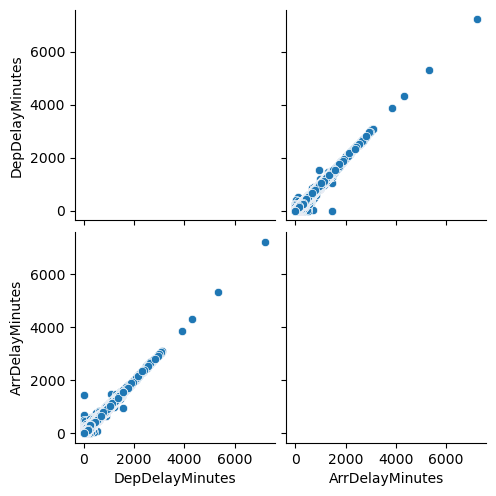

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for visualization
pdf = cleaned_flight.select(delay_columns).toPandas()

# Plotting
sns.pairplot(pdf)
plt.show()

In [ ]:
# Histograms for Delay Minutes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for visualization
pdf = cleaned_flight.select('DepDelayMinutes', 'ArrDelayMinutes').toPandas()

# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(pdf['DepDelayMinutes'], kde=True, color="skyblue")
plt.title('Histogram of Departure Delay Minutes')
plt.xlabel('Departure Delay Minutes')

plt.subplot(1, 2, 2)
sns.histplot(pdf['ArrDelayMinutes'], kde=True, color="olive")
plt.title('Histogram of Arrival Delay Minutes')
plt.xlabel('Arrival Delay Minutes')

plt.tight_layout()
plt.show()

In [ ]:
# Boxplot for Delays by Day of Week

# Convert to Pandas DataFrame
pdf = cleaned_flight.select('DayOfWeek', 'DepDelayMinutes').toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='DepDelayMinutes', data=pdf)
plt.title('Boxplot of Departure Delays by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Departure Delay Minutes')
plt.show()


In [ ]:
# Correlation Heatmap

# Selecting numerical columns for correlation
numerical_columns = ['DepDelayMinutes', 'ArrDelayMinutes', 'Distance']
pdf = cleaned_flight.select(numerical_columns).toPandas()

# Calculating correlation matrix
corr = pdf.corr()

# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


##### 4. Handling Missing Values

In [29]:
# Dropping rows with missing values
df_cleaned = cleaned_flight.na.drop()

# Or impute missing values, for example, with mean or median
from pyspark.sql.functions import mean

mean_val = cleaned_flight.agg(mean(cleaned_flight['PR_ARR_DEL15'])).first()[0]
df_filled = cleaned_flight.na.fill({'PR_ARR_DEL15': mean_val})

##### 5. Correlation Analysis

In [ ]:
# Assuming 'delay_columns' should only contain numeric columns
numeric_delay_columns = ['DepDelayMinutes', 'ArrDelayMinutes']  # Update this list based on your dataset

for col1 in numeric_delay_columns:
    for col2 in numeric_delay_columns:
        if col1 != col2:
            corr = df_cleaned.stat.corr(col1, col2)
            print(f"Correlation between {col1} and {col2}: {corr}")

### Feature Engineering and Data Preprocessing

In [ ]:
# Encoding Categorical Variables

from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Example: Encoding a categorical column
indexer = StringIndexer(inputCol='Operating_Airline', outputCol='Operating_Airline_Index')
df_cleaned = indexer.fit(df_cleaned).transform(df_cleaned)

encoder = OneHotEncoder(inputCols=['Operating_Airline_Index'], outputCols=['Operating_Airline_Encoded'])
df_cleaned = encoder.transform(df_cleaned)


In [ ]:
# Feature Scaling

from pyspark.ml.feature import StandardScaler

# Assemble numeric columns into a single vector column
assembler = VectorAssembler(inputCols=['DepDelayMinutes', 'Distance'], outputCol='features')
df_cleaned = assembler.transform(df_cleaned)

# Scale the features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
df_cleaned = scaler.fit(df_cleaned).transform(df_cleaned)


In [ ]:
#Feature Creation

from pyspark.sql.functions import col

# Example: Creating a new feature 'IsWeekend'
df_cleaned = df_cleaned.withColumn('IsWeekend', (col('DayOfWeek') > 5).cast('integer'))

In [ ]:
# Feature Selection

# Selecting features to include in the model
selected_columns = ['DepDelayMinutes', 'Distance', 'Operating_Airline_Encoded', 'IsWeekend', 'ArrDel15']
df_model = df_cleaned.select(selected_columns)


In [ ]:
# Putting it Together

from pyspark.ml import Pipeline

# Set up the stages of the pipeline
stages = [indexer, encoder, assembler, scaler]
pipeline = Pipeline(stages=stages)

# Apply the pipeline
df_transformed = pipeline.fit(df_cleaned).transform(df_cleaned)


### Model Building

In [ ]:
#1. Preparing the Data

# Splitting the data into training and test sets
train, test = df_transformed.randomSplit([0.7, 0.3])

##### Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="ArrDel15", featuresCol="scaledFeatures")

# Fit the model on the training data
dt_model = dt.fit(train)

# Make predictions on the test data
dt_predictions = dt_model.transform(test)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="ArrDel15")
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})

print(f"Decision Tree Accuracy: {dt_accuracy}")


##### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(labelCol="ArrDel15", featuresCol="scaledFeatures")

# Fit the model on the training data
rf_model = rf.fit(train)

# Make predictions on the test data
rf_predictions = rf_model.transform(test)

# Evaluate the model
rf_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})

print(f"Random Forest Accuracy: {rf_accuracy}")


##### Hyperparameter Tuning

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Example for Decision Tree
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.maxBins, [20, 30, 40]) \
    .build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="ArrDel15"),
                          numFolds=3)

# Fit the model
cv_model = crossval.fit(train)

# Evaluate on the test set
cv_predictions = cv_model.transform(test)
cv_accuracy = evaluator.evaluate(cv_predictions, {evaluator.metricName: "accuracy"})
print(f"Cross-Validated Accuracy: {cv_accuracy}")

### Model Evaluation

##### Evaluate with Basic Metrics

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="f1")

# Evaluate Decision Tree model
dt_accuracy = evaluator_accuracy.evaluate(dt_predictions)
dt_precision = evaluator_precision.evaluate(dt_predictions)
dt_recall = evaluator_recall.evaluate(dt_predictions)
dt_f1 = evaluator_f1.evaluate(dt_predictions)

# Evaluate Random Forest model
rf_accuracy = evaluator_accuracy.evaluate(rf_predictions)
rf_precision = evaluator_precision.evaluate(rf_predictions)
rf_recall = evaluator_recall.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)

print(f"Decision Tree - Accuracy: {dt_accuracy}, Precision: {dt_precision}, Recall: {dt_recall}, F1 Score: {dt_f1}")
print(f"Random Forest - Accuracy: {rf_accuracy}, Precision: {rf_precision}, Recall: {rf_recall}, F1 Score: {rf_f1}")


##### ROC Curve and AUC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# ROC and AUC for Decision Tree
dt_evaluator = BinaryClassificationEvaluator(labelCol="ArrDel15")
dt_auc = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "areaUnderROC"})

# ROC and AUC for Random Forest
rf_auc = dt_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "areaUnderROC"})

print(f"Decision Tree - AUC: {dt_auc}")
print(f"Random Forest - AUC: {rf_auc}")


##### Confusion Matrix

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert prediction results to RDD
rdd_dt = dt_predictions.select(['prediction', 'ArrDel15']).rdd
rdd_rf = rf_predictions.select(['prediction', 'ArrDel15']).rdd

# Instantiate metrics object
metrics_dt = MulticlassMetrics(rdd_dt)
metrics_rf = MulticlassMetrics(rdd_rf)

# Confusion matrix
print("Decision Tree - Confusion Matrix")
print(metrics_dt.confusionMatrix().toArray())

print("\nRandom Forest - Confusion Matrix")
print(metrics_rf.confusionMatrix().toArray())
